# Capstone Project - The Battle of Neighborhoods 

## Table of Contents

* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Finding](#Finding)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)

## 1. Introduction <a name="Introduction"></a>

In this project, we will be grouping neighborhoods in Toronto into three clusters, neighborhoods in city center, in the middle of center and outer city, and outer border of the city by using the frequency of occurrence of types of retail store located around each neighborhood. Specifically, the report is targeting to both home buyers and investors both local and foreign whom are considering owning or investing a house in a neighborhood based on their preference on whether they prefer near or outer border from the city. 

Since there are multiple types of retail store that can be found in Toronto, we are only interested in shopping mall, plaza, supermarket, department store, and big box store for analysis. The frequency of occurrence of the top two shopping types as mentioned above will be characteristic of each neighborhood for clustering. The neighborhoods will then be plotted on the folium map for visualization. 

## 2. Data <a name="Data"></a>

In light of our goal, following data is needed for analysis: 

  - Latitude, longitude and borough in which a neighborhood belongs to of each neighborhood
  - Types of retail store that are shopping mall, plaza, supermarket, department store, and big box store located nearby of each neighborhood and their respective latitude and longitude 

These information will be sourced from Wikipedia, FourSquare and readily available Geocode package. 

In [1]:
# Insta beautifulsoup package for WebScraping 
!pip install bs4

In [2]:
# Import the libraries for web scraping 
import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
import requests 

### 2.1 - Explore Neighborhoods in Toronto

We will extract the information of postal code and borough in which a neighborhood belongs in for every neighborhood from Wikipedia using library of BeautifulSoup to perform web scrapping. Once these information have been scrapped, it will then be merged with the dataset of readily available Geocode package that contains information of latitude and longitude of each neighborhood. 

In [3]:
# Neighborhoods in Toronto from Wikipedia 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [4]:
html = requests.get(url).text

In [5]:
soup = BeautifulSoup(html, 'html5lib')

In [6]:
# Using beautifulsoup to scrape the data 
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df1=pd.DataFrame(table_contents)
df1['Borough']=df1['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


In [7]:
# Extract the data of latitude and longitude of each neighborhood 
df = pd.read_csv('Geospatial_Coordinates.csv')

In [8]:
df.rename(columns={'Postal Code': 'PostalCode'}, inplace = True)

In [9]:
# Merging the two datasets from Wikipedia and Geocode package 
Toronto_df = pd.merge(df1, df, on=['PostalCode'])

In [10]:
Toronto_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


Together there are 5 columns of Postal Code, Borough, Neighborhood, Latitude and Longitude with 103 samples or neighborhoods can be identified in Toronto. 

In [11]:
Toronto_df['Neighborhood'].count()

103

In [12]:
# Number of neighborhoods under each borough 
Toronto_df['Borough'].value_counts()

North York                24
Downtown Toronto          17
Scarborough               17
Etobicoke                 11
Central Toronto            9
West Toronto               6
York                       5
East Toronto               4
East York                  4
East Toronto Business      1
Mississauga                1
East York/East Toronto     1
Downtown Toronto Stn A     1
Etobicoke Northwest        1
Queen's Park               1
Name: Borough, dtype: int64

### 2.2 - Plotting Each Neighborhood on Folum Map

In [13]:
# Install folium and geopy 
!pip install folium
!pip install geopy

In [14]:
from geopy.geocoders import Nominatim 
import folium 

import matplotlib.cm as cm 
import matplotlib.colors as colors 

from sklearn.cluster import KMeans 

In [15]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Toronto, Ontario")
location = geolocator.geocode(address)
latitude = location.latitude 
longitude = location.longitude

The markings of each neighborhood can be clearly seen on the folium map. Together there are 103 marking on the map. 

In [16]:
Map_Toronto1 = folium.Map(location=[latitude,longitude], zoom_start = 11)

for lat, lng, label in zip (Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color='blue',
        fill=True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(Map_Toronto1)

Map_Toronto1

### 2.3 - Explore the Retail Stores that are Nearby in Each Neighborhood 

The next piece of information that we are interested in is types of retail store located nearby to each neighborhood and their respective latitude and longitude. This information will be obtained from FourSquare using API call. The radius will be set to 8km from the center grid of each neighborhood. Information that are not relevant being obtained under category id of 4bf58dd8d48988d1fd941735, category id assigned to Shopping Mall in FourSquare will be excluded from our analysis. 

In [17]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20210825'
radius = 8000
LIMIT = 100 
categoryId = '4bf58dd8d48988d1fd941735'

In [18]:
def getNearbyVenues(borough, neighborhood, latitudes, longitudes, radius=8000):
    
    venues_list=[]
    for borough, neighborhood, lat, lng in zip(borough, neighborhood, latitudes, longitudes):

        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categoryId,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            neighborhood,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                             
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
           
    
    return(nearby_venues)

Let's apply the above created function on Toronto neighborhoods. 

In [19]:
Toronto_venues1 = getNearbyVenues(borough = Toronto_df['Borough'],
                                neighborhood = Toronto_df['Neighborhood'],
                                latitudes = Toronto_df['Latitude'],
                                longitudes = Toronto_df['Longitude']
                            )
Toronto_venues1

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.753259,-79.329656,CF Shops at Don Mills,43.735011,-79.344787,Shopping Mall
1,North York,Parkwoods,43.753259,-79.329656,CF Fairview Mall,43.777981,-79.344397,Shopping Mall
2,North York,Parkwoods,43.753259,-79.329656,Bayview Village,43.768527,-79.385494,Shopping Mall
3,North York,Parkwoods,43.753259,-79.329656,Scarborough Town Centre,43.775277,-79.257413,Shopping Mall
4,North York,Parkwoods,43.753259,-79.329656,Leaside Village,43.705682,-79.360777,Shopping Mall
...,...,...,...,...,...,...,...,...
4999,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Sino Mall,43.597794,-79.594803,Shopping Mall
5000,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Petro-Canada,43.636354,-79.475463,Gas Station
5001,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Crossways Mall,43.656775,-79.452498,Shopping Mall
5002,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,BlackBerry Tahoe B,43.638382,-79.607973,Office


Let's check how many types of venue were obtained from FourSquare. Types of venue that are not relevant to our analysis will be excluded from the data set. 

In [20]:
Toronto_venues1['Venue Category'].value_counts()

Shopping Mall             3999
Clothing Store             131
Plaza                      101
Pharmacy                    93
Office                      93
Supermarket                 74
Grocery Store               71
Department Store            53
Big Box Store               50
Women's Store               49
General Travel              43
Building                    42
Miscellaneous Shop          39
Shoe Store                  38
Gas Station                 36
Accessories Store           27
Mobile Phone Shop           21
Furniture / Home Store      21
Electronics Store           16
Shopping Plaza               4
Jewelry Store                3
Name: Venue Category, dtype: int64

### 2.4 - Data Preparation

As mentioned earlier that we are only interested in shopping mall, plaza, supermarket, department store and big box store nearby to each neighborhood for our analysis, others will be excluded from the dataset.  

In [21]:
Toronto_Shop = Toronto_venues1[Toronto_venues1['Venue Category'].isin(['Shopping Mall', 'Plaza','Supermarket','Department Store','Big Box Store'])]
Toronto_Shop 

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.753259,-79.329656,CF Shops at Don Mills,43.735011,-79.344787,Shopping Mall
1,North York,Parkwoods,43.753259,-79.329656,CF Fairview Mall,43.777981,-79.344397,Shopping Mall
2,North York,Parkwoods,43.753259,-79.329656,Bayview Village,43.768527,-79.385494,Shopping Mall
3,North York,Parkwoods,43.753259,-79.329656,Scarborough Town Centre,43.775277,-79.257413,Shopping Mall
4,North York,Parkwoods,43.753259,-79.329656,Leaside Village,43.705682,-79.360777,Shopping Mall
...,...,...,...,...,...,...,...,...
4997,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Rockwood Mall,43.625328,-79.604702,Shopping Mall
4998,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Galleria Shopping Centre,43.667592,-79.442053,Shopping Mall
4999,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Sino Mall,43.597794,-79.594803,Shopping Mall
5001,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Crossways Mall,43.656775,-79.452498,Shopping Mall


In [22]:
# Number of stores under each retail store type 
Toronto_Shop['Venue Category'].value_counts()

Shopping Mall       3999
Plaza                101
Supermarket           74
Department Store      53
Big Box Store         50
Name: Venue Category, dtype: int64

In [23]:
Toronto_Shop.groupby(['Borough','Neighborhood','Venue Category']).count()

Neighborhood Latitude  \
Borough         Neighborhood                  Venue Category                            
Central Toronto Davisville                    Big Box Store                         1   
                                              Department Store                      1   
                                              Plaza                                 2   
                                              Shopping Mall                        56   
                                              Supermarket                           1   
...                                                                               ...   
York            Humewood-Cedarvale            Shopping Mall                        49   
                                              Supermarket                           1   
                Runnymede, The Junction North Big Box Store                         1   
                                              Shopping Mall                        33   
                Weston                        Shopping Mall                        25   

                                                                Neighborhood Longitude  \
Borough         Neighborhood                  Venue Category                             
Central Toronto Davisville                    Big Box Store                          1   
                                              Department Store                       1   
                                              Plaza                                  2   
                                              Shopping Mall                         56   
                                              Supermarket                            1   
...                                                                                ...   
York            Humewood-Cedarvale            Shopping Mall                         49   
                                              Supermarket                            1   
                Runnymede, The Junction North Big Box Store                          1   
                                              Shopping Mall                         33   
                Weston                        Shopping Mall                         25   

                                                                Venue  \
Borough         Neighborhood                  Venue Category            
Central Toronto Davisville                    Big Box Store         1   
                                              Department Store      1   
                                              Plaza                 2   
                                              Shopping Mall        56   
                                              Supermarket           1   
...                                                               ...   
York            Humewood-Cedarvale            Shopping Mall        49   
                                              Supermarket           1   
                Runnymede, The Junction North Big Box Store         1   
                                              Shopping Mall        33   
                Weston                        Shopping Mall        25   

                                                                Venue Latitude  \
Borough         Neighborhood                  Venue Category                     
Central Toronto Davisville                    Big Box Store                  1   
                                              Department Store               1   
                                              Plaza                          2   
                                              Shopping Mall                 56   
                                              Supermarket                    1   
...                                                                        ...   
York            Humewood-Cedarvale            Shopping Mall                 49   
                                              S

Now, we are going to identify the top two types of retail store that are frequently occurred in a neighborhood. Before that we will have to create dummy variable for each retail store type as the analysis requires integer or floating type of data. 

In [24]:
Toronto_onehot = pd.get_dummies(Toronto_Shop[['Venue Category']], prefix="", prefix_sep="")

# Adding back the columns of Neighborhood, Borough, and Venue to the newly created data frame, Toronto_onehot 
Toronto_onehot['Neighborhood'] = Toronto_Shop['Neighborhood']

Toronto_onehot['Borough'] = Toronto_Shop['Borough']

Toronto_onehot['Venue'] = Toronto_Shop['Venue'] 

# Setting the the first three columns with Neighborhood comes first followed by Borough and Venue 
fixed_columns = list(Toronto_onehot.columns[-3:]) + list(Toronto_onehot.columns[:-3])

Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot

,Neighborhood,Borough,Venue,Big Box Store,Department Store,Plaza,Shopping Mall,Supermarket
0,Parkwoods,North York,CF Shops at Don Mills,0,0,0,1,0
1,Parkwoods,North York,CF Fairview Mall,0,0,0,1,0
2,Parkwoods,North York,Bayview Village,0,0,0,1,0
3,Parkwoods,North York,Scarborough Town Centre,0,0,0,1,0
4,Parkwoods,North York,Leaside Village,0,0,0,1,0
...,...,...,...,...,...,...,...,...
4997,"Mimico NW, The Queensway West, South of Bloor,...",Etobicoke,Rockwood Mall,0,0,0,1,0
4998,"Mimico NW, The Queensway West, South of Bloor,...",Etobicoke,Galleria Shopping Centre,0,0,0,1,0
4999,"Mimico NW, The Queensway West, South of Bloor,...",Etobicoke,Sino Mall,0,0,0,1,0
5001,"Mimico NW, The Queensway West, South of Bloor,...",Etobicoke,Crossways Mall,0,0,0,1,0


Let's group by borough followed by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [25]:
Toronto_grouped = Toronto_onehot.groupby(['Borough','Neighborhood']).mean().reset_index()
Toronto_grouped

,Borough,Neighborhood,Big Box Store,Department Store,Plaza,Shopping Mall,Supermarket
0,Central Toronto,Davisville,0.016393,0.016393,0.032787,0.918033,0.016393
1,Central Toronto,Davisville North,0.015873,0.015873,0.031746,0.920635,0.015873
2,Central Toronto,Forest Hill North & West,0.018182,0.018182,0.036364,0.909091,0.018182
3,Central Toronto,Lawrence Park,0.000000,0.000000,0.018182,0.963636,0.018182
4,Central Toronto,"Moore Park, Summerhill East",0.017857,0.017857,0.035714,0.928571,0.000000
...,...,...,...,...,...,...,...
98,York,Caledonia-Fairbanks,0.018868,0.018868,0.037736,0.905660,0.018868
99,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",0.027027,0.000000,0.027027,0.918919,0.027027
100,York,Humewood-Cedarvale,0.018519,0.018519,0.037037,0.907407,0.018519
101,York,"Runnymede, The Junction North",0.029412,0.000000,0.000000,0.970588,0.000000


In [26]:
Toronto_grouped.shape

(103, 7)

We will now identify the top two retail store types for each neighborhood based on the frequency of the occurrence. 

In [27]:
num_top_venues = 2 

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})

    print(temp.sort_values('freq',ascending=False).reset_index(drop=True).head(num_top_venues))

----Davisville----
           venue  freq
0  Shopping Mall  0.92
1          Plaza  0.03
----Davisville North----
           venue  freq
0  Shopping Mall  0.92
1          Plaza  0.03
----Forest Hill North & West----
           venue  freq
0  Shopping Mall  0.91
1          Plaza  0.04
----Lawrence Park----
           venue  freq
0  Shopping Mall  0.96
1          Plaza  0.02
----Moore Park, Summerhill East----
           venue  freq
0  Shopping Mall  0.93
1          Plaza  0.04
----North Toronto West----
           venue  freq
0  Shopping Mall  0.91
1          Plaza  0.04
----Roselawn----
           venue  freq
0  Shopping Mall  0.90
1          Plaza  0.03
----Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park----
           venue  freq
0  Shopping Mall  0.90
1          Plaza  0.04
----The Annex, North Midtown, Yorkville----
           venue  freq
0  Shopping Mall  0.90
1          Plaza  0.04
----Berczy Park----
           venue  freq
0  Shopping Mall  0.88
1          Plaza

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Toronto_venues_sorted = pd.DataFrame(columns=columns)
Toronto_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    Toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

Toronto_venues_sorted


,Neighborhood,1st Most Common Venue,2nd Most Common Venue
0,Davisville,Shopping Mall,Plaza
1,Davisville North,Shopping Mall,Plaza
2,Forest Hill North & West,Shopping Mall,Plaza
3,Lawrence Park,Shopping Mall,Supermarket
4,"Moore Park, Summerhill East",Shopping Mall,Plaza
...,...,...,...
98,Caledonia-Fairbanks,Shopping Mall,Plaza
99,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Shopping Mall,Supermarket
100,Humewood-Cedarvale,Shopping Mall,Plaza
101,"Runnymede, The Junction North",Shopping Mall,Big Box Store


## 3. Methodology <a name="Methodology"></a>

### 3.1 - K-Nearest Clustering 

The main function of the K-nearest clustering technique is to cluster neighborhoods that have similar characteristic into clusters of neighborhoods. As mentioned in the beginning that we will use the top two retail store types based on the frequency of occurrence as the characteristic for clustering. The three clusters are the clusters that are at the center, in between the center and outer, and outer. These three clusters will then be plotted on the folium map.

The K-Nearest Neighbors algorithm is performed in the following steps: 
 -  As we have identified the top two retail store types located within 8km radius from the grid center of the neighborhood, we will now use the information to cluster into three clusters by setting the number of clusters to 3 
 -  Once performing the K-nearest function, each neighborhood will be assigned a label range from 0 to 2 
 -  This information will then be used to plot on the folium map 

In [30]:
kclusters = 3 
Toronto_grouped_clustering = Toronto_grouped.drop(['Borough','Neighborhood'], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)
kmeans.labels_[0:3]

array([2, 2, 1], dtype=int32)

In [31]:
# Insert the Cluster Labels in new columns 
Toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Create a new dataframe 
Toronto_Neigh = Toronto_df

# Merge the dataframe with venues characteristics for each neighborhood with dataframe that has the information regarding the neighborhood 
Toronto_Neigh = Toronto_Neigh.join(Toronto_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_Neigh.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Shopping Mall,Supermarket
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Shopping Mall,Supermarket
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Shopping Mall,Plaza
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Shopping Mall,Supermarket
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,Shopping Mall,Plaza


In [32]:
# The dataset has 103 neighborhoods which is same as the number of samples in the raw data 
Toronto_Neigh

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Shopping Mall,Supermarket
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Shopping Mall,Supermarket
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Shopping Mall,Plaza
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Shopping Mall,Supermarket
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,Shopping Mall,Plaza
...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,2,Shopping Mall,Department Store
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Shopping Mall,Plaza
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,1,Shopping Mall,Plaza
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,2,Shopping Mall,Department Store


## 4. Finding <a name="Finding"></a>

The three clusters are plotted on the folium map. Based on the markings plotted on the folium map, it can be clearly seen that neighborhoods in the purple cluster located in the center of the Toronto, light green at the middle of center and outer, and red is outer border of Toronto city. 

In [33]:
map_clusters1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_Neigh['Latitude'], Toronto_Neigh['Longitude'], Toronto_Neigh['Neighborhood'], Toronto_Neigh['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

In [34]:
Toronto_Neigh["Cluster Labels"].value_counts()

1    40
0    34
2    29
Name: Cluster Labels, dtype: int64

In [44]:
df = pd.DataFrame(np.array([['At the City Center',40],['At the Middle of Center and Outer Border City',29],['At the Outer Border City',34]]),columns=['Clusters','Number of Neighborhoods'])
df

,Clusters,Number of Neighborhoods
0,At the City Center,40
1,At the Middle of Center and Outer Border City,29
2,At the Outer Border City,34


In [47]:
df.dtypes

Clusters                   object
Number of Neighborhoods    object
dtype: object

In [48]:
df['Number of Neighborhoods'] = df['Number of Neighborhoods'].astype(int, copy=True)

In [49]:
# Plot the graph showing the number of neighborhoods within each cluster 
import seaborn as sns 

[Text(0.5, 1.0, 'Number of Neighborhoods in Each Cluster')]

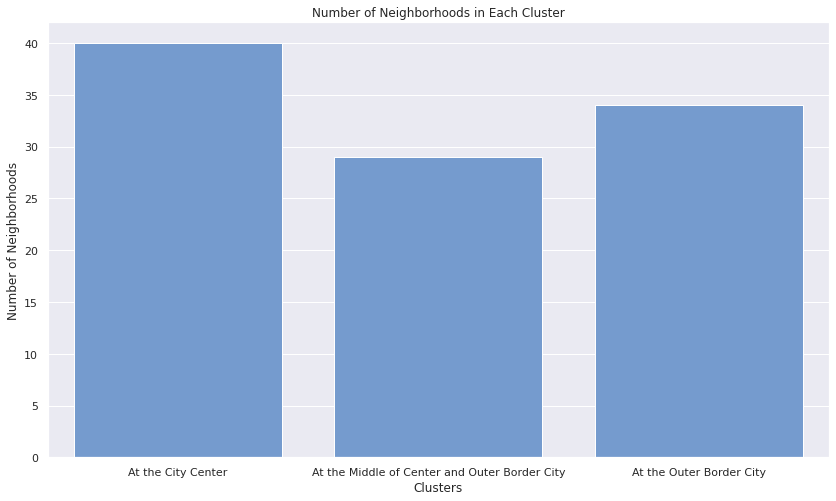

In [52]:
sns.set(rc={'figure.figsize':(14,8)})

sns.barplot(x='Clusters',y='Number of Neighborhoods', data=df, color = '#69d').set(title='Number of Neighborhoods in Each Cluster')

## 5. Discussion <a name="Discussion"></a>

The report has successfully grouping neighborhoods into clusters of neighborhoods at the center, in between center and outer, and outer city. There are 40 neighborhoods are located at the center city, 29 at the middle in between center and outer and 34 at the outer city. The analysis is useful for investors and home buyers to decide which neighborhood that they will choose based on the preference of location. It can as well be an indicator or as a proxy to measure the relative average housing price. For instance, on average, housing price in neighborhoods that are located in purple cluster is higher than average housing price located in both light green and red. 

## 6. Conclusion <a name="Conclusion"></a>

The business problem of helping to locate neighborhoods that are in the center, in between center and outer, and outer Toronto city has been addressed. The analysis report not only helping investors and home buyers to identify the neighborhood location whether be in city center or outer as well could use this finding of the report could act as a reference or a proxy to measure the relative average housing price between the 'clusters' of neighborhoods. The final decision will still on investor and home buyer regarding which neighborhood they are interested in. 

## THE END 